# Plotting degree distributions in python

Adapted from: Prof. Michael Szell and TA David Deritei, who in turn adapted from Jeff Alstott, available at: https://github.com/jeffalstott/powerlaw/blob/master/manuscript/Manuscript_Code.ipynb.


## Overview

In this notebook we use the powerlaw library to:
* Take a distribution from a real data set, plot it, and check if it follows a power law
* Compare the alternative fit of a lognormal

Sources:
* https://arxiv.org/abs/0706.1062
* http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777

## Setup

### Import libraries

In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore') # supressing some warnings - only do this is you know what you are doing
from numpy import genfromtxt
#you may have to install the powerlaw package! 
import powerlaw
print(powerlaw.__version__)
from pprint import pprint # pretty print

#plotting stuff
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

1.4.3


In [2]:
# change fonts to be less ugly
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
matplotlib.rc('font', size=16)
matplotlib.rc('xtick.major', size=6, width=1)
matplotlib.rc('xtick.minor', size=3, width=1)
matplotlib.rc('ytick.major', size=6, width=1)
matplotlib.rc('ytick.minor', size=3, width=1)
matplotlib.rc('axes', linewidth=1)

### Load data

Let us load the data: The word frequencies of the book "Moby Dick". We don't have to consider the degree distribution of a network to get a heterogeneous distribution!


In [29]:
word_counts=requests.get('https://raw.github.com/jeffalstott/powerlaw/master/manuscript/words.txt').text.strip()
data=[int(x) for x in word_counts.split('\n')]
pprint(data[:10]) # Check if data has loaded correctly

[14086, 6414, 6260, 4573, 4484, 4040, 2917, 2483, 2374, 1942]


The most common word in Moby Dick is "the", appearing 14086 times. The next one is "of", 6414 times, etc.

## Plotting the data

First, we plot the probability density function (pdf) with linear (red) and logarithmic (blue) bins. This is achieved with the method plot_pdf and the parameter linear_bins.

Text(0,0.5,'pdf $P(X)$')

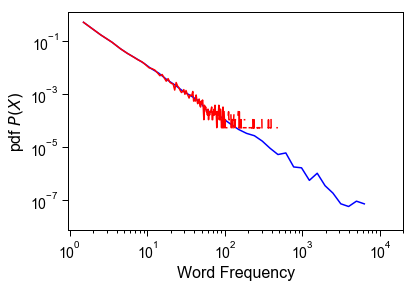

In [30]:
fig01 = powerlaw.plot_pdf(data, color='b')
powerlaw.plot_pdf(data, linear_bins=True, color='r', ax=fig01)

fig01.set_xlabel("Word Frequency")
fig01.set_ylabel(r"pdf $P(X)$")

The linear bins show a lot of noise, while logarithmic bins show a smoother tail. Usually we try to avoid using linear bins because of that. Logarithmic bins are better, but are also not optimal, as they can visually distort the data (e.g. you can change the appearance of the data by playing around with the binning).

As an alternative way to do this, next we create the logarithmic bins ourselves, using np.logspace and np.histogram, without using the powerlaw library.

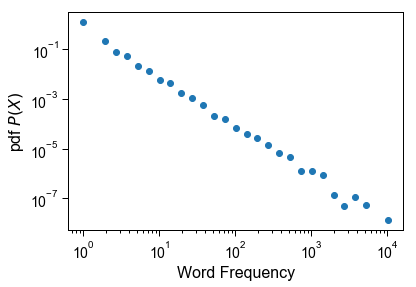

In [31]:
bin_edges = np.logspace(np.log10(min(data)), np.log10(max(data)), num=30)
density, _ = np.histogram(data, bins=bin_edges, density=True)
fig02 = plt.figure()
plt.loglog(bin_edges[:-1], density, marker='o', linestyle='none')

plt.xlabel("Word Frequency")
plt.ylabel(r"pdf $P(X)$")
plt.show()

Next, we plot the complementary cumulative distribution function (ccdf, red) in addition to the pdf (blue), using the methods plot_pdf and plot_ccdf. The ccdf is monotonically decreasing, less noisy than the pdf, and usually the preferred way to visualize a heavy-tailed distribution. Its slope is flatter though.

Text(0.5,0,'Word Frequency x')

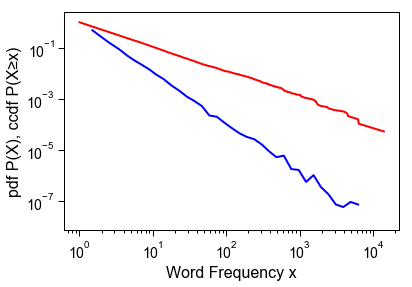

In [32]:
fig03 = powerlaw.plot_pdf(data, color='b', linewidth=2)
powerlaw.plot_ccdf(data, color='r', linewidth=2, ax=fig03)

fig03.set_ylabel(u"pdf P(X), ccdf P(X≥x)")
fig03.set_xlabel(r"Word Frequency x")

## Download a simple, unweighted, undirected network from https://icon.colorado.edu/ and plot its degree distribution!

# Fitting a power law

The class powerlaw.Fit makes a fit to the data and gives us an object with the same methods as before: plot_pdf, plot_ccdf, and more

For a full description of the parameters and methods, see: http://pythonhosted.org/powerlaw/#powerlaw.Fit

In [33]:
# https://stackoverflow.com/questions/1911281/how-do-i-get-list-of-methods-in-a-python-class
[method_name for method_name in dir(powerlaw.Fit) if callable(getattr(powerlaw.Fit, method_name)) and not method_name.startswith("__")]

['ccdf',
 'cdf',
 'distribution_compare',
 'find_xmin',
 'loglikelihood_ratio',
 'nested_distribution_compare',
 'pdf',
 'plot_ccdf',
 'plot_cdf',
 'plot_pdf']

#### Estimating the exponent alpha and lower bound xmin

We start fitting a power law. Running powerlaw.Fit gives us also a bunch of estimated parameters and data points that we can plot and investigate to see whether the power law hypothesis should be rejected or not. Let's see first all the variables that the Fit class generates:

In [37]:
fit = powerlaw.Fit(data, discrete=True)
fit.alpha,fit.xmin

Calculating best minimal value for power law fit


(1.9501572269094178, 7.0)

Now let's use the data and plot the pdf and ccdf together with their fits:

Text(0.5,0,'Word Frequency')

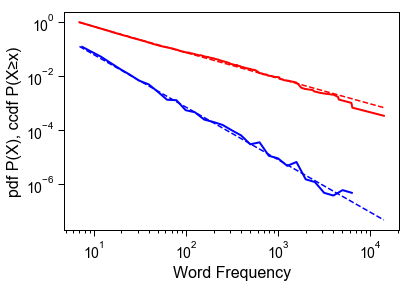

In [38]:
fig04 = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig04)
fit.plot_ccdf(color='r', linewidth=2, ax=fig04)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig04)

fig04.set_ylabel(u"pdf P(X), ccdf P(X≥x)")
fig04.set_xlabel(r"Word Frequency")

Looks pretty good. The relevant fitting parameters are:

In [39]:
print("alpha ± sigma: " + str(round(fit.alpha, 3)) +" ± "+str(round(fit.sigma, 3)))
print("xmin: " + str(round(fit.xmin)))

alpha ± sigma: 1.95 ± 0.017
xmin: 7.0


How is xmin determined? By doing fits for all possible x values, and taking xmin where the KS-distance D is minimal. This information is contained in the powerlaw.Fit object, which we can visualize too. 

Just for illustration, the next figure shows our attempt to fit the whole data (green curves): apparently, the fit looks really worse than fitting only the tail that starts at xmin=7 (blue dashed line)

'Fitting the tail considers 2958 data points.'
'Fitting the whole data set considers 18855 data points.'


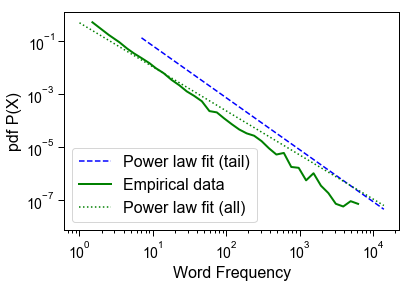

In [40]:
fig05 = fit.power_law.plot_pdf(color='b', linestyle='--', label='Power law fit (tail)') # blue dashed line: best fit for xmin = 7
pprint("Fitting the tail considers " +  str(round(fit.n_tail)) + " data points.")

fitxmin1 = powerlaw.Fit(data, xmin=1, discrete=True)
pprint("Fitting the whole data set considers " +  str(round(fitxmin1.n_tail)) + " data points.")
fitxmin1.plot_pdf(color='g', linewidth=2, ax=fig05, label='Empirical data') # green thick line: full data set
fitxmin1.power_law.plot_pdf(linestyle=':', color='g', ax=fig05, label='Power law fit (all)') # green dotted line: best fit for xmin = 1

handles, labels = fig05.get_legend_handles_labels()
fig05.set_ylabel(u"pdf P(X)")
fig05.set_xlabel(r"Word Frequency")
fig05.legend(handles, labels, loc=3)

We can investigate how D looks for different xmins. The next two figures show it is really minimal for xmin=7.

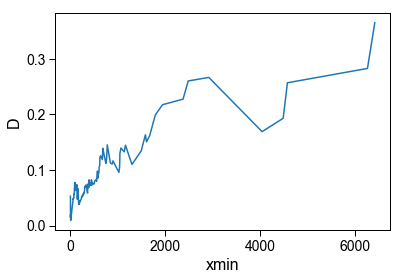

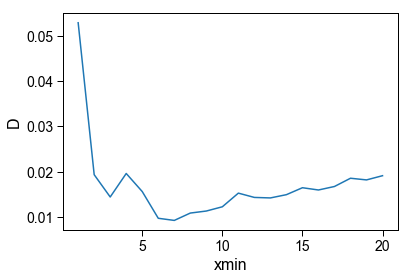

In [41]:
fig06 = plt.figure()
plt.plot(fit.xmins, fit.Ds)
plt.xlabel("xmin")
plt.ylabel("D")
plt.show()

fig07 = plt.figure()
plt.plot(fit.xmins[:20], fit.Ds[:20])
plt.xlabel("xmin")
plt.ylabel("D")
plt.show()

## The remaining material is for the enjoyment of students interested in analyzing the statistical validity of powerlaw fits, ideally with some background in statistics. 

#### Testing the goodness of fit

So far so good. The powerlaw package gave us an alpha and an xmin. But it would have given us two values for ANY data set. So we need to check the goodness of fit - we follow the method of Clauset et al: We create simulated tails with the same number of tail data points and the same parameters xmin and alpha, and glue them together with the head. For each of these data sets we fit a power law and record the KS statistic. To be accurate, we would have to create around 10,000 data sets, which takes time; for demonstration purposes we just do 50 here.

In [42]:
numsim = 50 # number of synthetic data sets

Ds_simulated = [None]*numsim # list of synthetic KS statistics
data_head = np.array([data[i] for i in range(len(data)) if data[i] < int(fit.xmin)])

for i in range(numsim):
    theoretical_distribution = powerlaw.Power_Law(xmin=fit.xmin, parameters=[fit.alpha])
    simulated_data = theoretical_distribution.generate_random(round(fit.n_tail)) # simulated tail data
    simulated_data = np.append(data_head, simulated_data) # put together simulated tail with real head
    if i == 0:
        pprint(simulated_data) # Show the first sythetic data set, to make sure we did it correctly
    fit_simulated = powerlaw.Fit(simulated_data, verbose=True)
    Ds_simulated[i] = fit_simulated.D

array([ 6.        ,  6.        ,  6.        , ..., 39.90671387,
        9.12403421, 18.07015627])


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Now: Calculate the p-value as the fraction of the KS statistics for the synthetic data sets whose value exceeds the KS statistic for the real data.

In [48]:
Ds_simulated = np.array(Ds_simulated)
pval = len(Ds_simulated[Ds_simulated > fit.D]) / len(Ds_simulated)
pprint("The p-value " + str(pval) + " is >0.1, therefore we cannot reject the power law hypothesis.")

'The p-value 0.58 is >0.1, therefore we cannot reject the power law hypothesis.'


Visually, this means that the KS statistic of the real data (yellow line) is left of the 0.9-quantile of the distribution of synthetic KS statistics (red line):

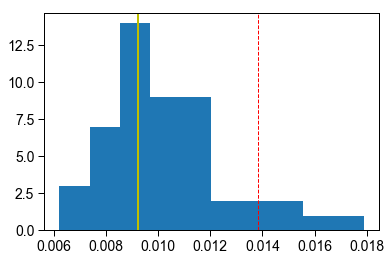

In [49]:
plt.hist(Ds_simulated)
plt.axvline(x=fit.D, color='y', linewidth=2)
plt.axvline(x=np.percentile(Ds_simulated, 90), color='r', linewidth=1, linestyle='--') 
plt.show()

Only if the yellow line had come out to the right of the red line, we would have had to reject the power law hypothesis.

### Fitting a lognormal, and comparing it with the power law fit

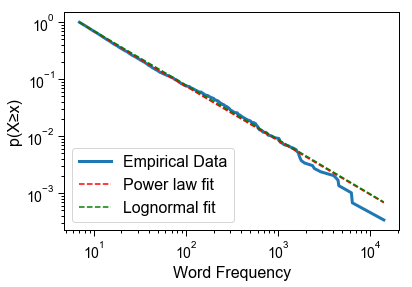

In [50]:
fit.distribution_compare('power_law', 'lognormal')
fig08 = fit.plot_ccdf(linewidth=3, label='Empirical Data')
fit.power_law.plot_ccdf(ax=fig08, color='r', linestyle='--', label='Power law fit')
fit.lognormal.plot_ccdf(ax=fig08, color='g', linestyle='--', label='Lognormal fit')

fig08.set_ylabel(u"p(X≥x)")
fig08.set_xlabel("Word Frequency")
handles, labels = fig08.get_legend_handles_labels()
fig08.legend(handles, labels, loc=3)

It looks like a lognormal could fit the same way as a power law. Let's investigate the parameters:

In [51]:
print("mu: " + str(round(fit.lognormal.mu, 3)))
print("sigma: " + str(round(fit.lognormal.sigma, 3)))

mu: -723.877
sigma: 27.66


Strange that mu is negative. Maybe lognormal is not a good fit after all? Let's compare power law with lognormal:

In [52]:
R,p = fit.distribution_compare('power_law', 'lognormal')
print("R: " + str(round(R, 4)))
print("p-value: " + str(round(p, 2)))

R: 0.0088
p-value: 0.95


R is the likelihood ratio between the two candidate distributions. Because it is positive, the data is more likely to follow the first distribution, i.e. the power law. However, the p-value is larger than 0.1, so this distinction is not significant. 

Stopping here, we conclude that the power law is a good fit to the data, but we cannot exclude that a lognormal could fit as well.

## Try to carry out the same analysis on the empirical network you downloaded earlier.